# **DLIP Tutorial - PyTorch**

## MNIST Classification using PyTorch
Y.-K. Kim
(updated 2024. 4. 29)



## For CoLab Usage:

1. Download this notebook
2. Then, open in Colab

The purpose of this tutorial is to learn how to build a simple Multi-Layer Percentron (MLP or ANN) for classification of handwritting digits (MNIST)

===================

## Setup Pytorch and Numpy and GPU

In [46]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np 
import matplotlib.pyplot as plt

print(torch.__version__)

2.7.0+cu128


In [47]:
# Select GPU or CPU for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Prepare Datasets
### OpenDataset from TorchVision


1. Loading OpenDataset (Fashion MNIST) from Pytorch data
* ``Dataset``:  stores the samples and their corresponding labels
* ``DataLoader`` wraps an iterable around the ``Dataset``.


In [48]:
# Download Dataset from TorchVision MNIST
# Once, downloaded locally, it does not download again.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),   #converts 0~255 value to 0~1 value.
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

2. Use  ``DataLoader`` to  make dataset iterable.
* supports automatic batching, sampling, shuffling and multiprocess data loading.



In [49]:
# Create DataLoader with Batch size N
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    # N = batch_size, C = chanel, 
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


3. Plot some training data


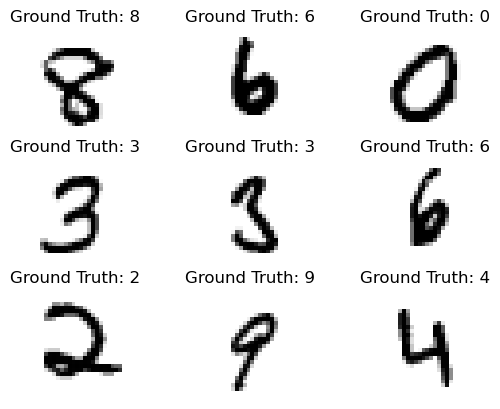

In [50]:
# Visualize some Datasets
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')
    plt.title("Ground Truth: {}".format(labels[index]))
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Define model

create a class that inherits from nn.Module


* Define the layers of the network in  __init__ function
* Specify Forward network in the **forward function.**

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)


* Image Input: 1x28x28  image
* Flatten into a 1*784 element vector
* 1st Layer: linear to 250 dimensions / ReLU
* 2nd Layer: linear to 100 dim / ReLU
* 3rd Layer: linear to 10 dim / log SoftMax
* Output:  1x10

Actication function: ReLU

**NOTE**


1) nn.Linear(InputDim, OutputDim)


2) x.view( )
* Similar to  NumPy Reshape(). /// [batch size, height * width]

In [51]:
# Model Architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()             # 2D -> 1D
        self.linear1 = nn.Linear(28*28, 250)    # Weight
        self.linear2 = nn.Linear(250, 100)      # 
        self.linear3 = nn.Linear(100, 10)


    def forward(self, x):
        x=self.flatten(x)
        x= F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y_pred = F.log_softmax(self.linear3(x))
        return y_pred


model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


## Weight Initialization
 In Keras, dense layers by default uses “glorot_uniform” random initializer, it is also called Xavier normal initializer.

# Optimization Setup  

### Optmizer function
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available,
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

1. Linear regression->Mean Squared Error
2. Classification->Cross entropy,

In [52]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)    # Loss 기울기 -> Weight Update

# Train the model
### Define train() function
Reuse this function in other tutorials


In [53]:
# Train Module
def train(dataloader, model, loss_fn, optimizer):
    # Dataset Size
    size = len(dataloader.dataset)
    
    # Model in Training Mode
    model.train()

    running_loss=0.0

    for batch, (X, y) in enumerate(dataloader):     # X: Batch, y = Label
        X, y = X.to(device), y.to(device)

        # zero gradients for every batch
        optimizer.zero_grad()   

        # Compute prediction loss 
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation and Update        
        loss.backward()
        optimizer.step()        

        # Print loss for every 100 batch in an epoch
        running_loss+=loss.item()
        if batch % 100 == 0:
            running_loss=running_loss/100
            current = batch * len(X)
            print(f"loss: {running_loss:>7f}  [{current:>5d}/{size:>5d}]")
            running_loss=0

### Train
Print training process

In [54]:
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.023142  [    0/60000]


C:\Users\Sangheon\AppData\Local\Temp\ipykernel_29672\889195615.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


loss: 2.303102  [ 6400/60000]
loss: 2.301183  [12800/60000]
loss: 2.296006  [19200/60000]
loss: 2.294169  [25600/60000]
loss: 2.290559  [32000/60000]
loss: 2.286496  [38400/60000]
loss: 2.283567  [44800/60000]
loss: 2.281484  [51200/60000]
loss: 2.276580  [57600/60000]
Epoch 2
-------------------------------
loss: 0.022723  [    0/60000]
loss: 2.271342  [ 6400/60000]
loss: 2.265810  [12800/60000]
loss: 2.263070  [19200/60000]
loss: 2.259035  [25600/60000]
loss: 2.252522  [32000/60000]
loss: 2.248919  [38400/60000]
loss: 2.243382  [44800/60000]
loss: 2.238076  [51200/60000]
loss: 2.233184  [57600/60000]
Epoch 3
-------------------------------
loss: 0.022321  [    0/60000]
loss: 2.222424  [ 6400/60000]
loss: 2.217766  [12800/60000]
loss: 2.209396  [19200/60000]
loss: 2.203542  [25600/60000]
loss: 2.195581  [32000/60000]
loss: 2.187788  [38400/60000]
loss: 2.178310  [44800/60000]
loss: 2.169333  [51200/60000]
loss: 2.158847  [57600/60000]
Epoch 4
-------------------------------
loss: 0.02

# Test the model  ``eval()``

### Define **test()** function
Using ``eval()`` for test. Evaluate mode로 전환
This function can be reused in other tutorials

In [55]:
def test(dataloader, model, loss_fn):
    # Dataset Size
    size = len(dataloader.dataset)

    # Batch Size
    num_batches = len(dataloader)
    
    # Model in Evaluation Mode
    model.eval()

    test_loss, correctN = 0, 0
    
    # Disable grad() computation to reduce memory consumption.
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Compute average prediction loss 
            pred = model(X)            
            test_loss += loss_fn(pred, y).item()

            # Predict Label
            y_pred=pred.argmax(1);
            correctN += (y_pred == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correctN /= size
    print(f"Test Error: \n Accuracy: {(100*correctN):>0.1f}%, Avg loss: {test_loss:>8f} \n")



### Test
Print test data accuracy

In [56]:
test(test_dataloader, model, loss_fn)

C:\Users\Sangheon\AppData\Local\Temp\ipykernel_29672\889195615.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


Test Error: 
 Accuracy: 91.8%, Avg loss: 0.284934 



### Visualize Evaluation Results

Select random test images and evaluate

In [57]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
print(images.size())

# Evaluate mode
# Prediction of some sample images 
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    pred = model(images)
    _, predicted = torch.max(pred.data, 1)


torch.Size([64, 1, 28, 28])


C:\Users\Sangheon\AppData\Local\Temp\ipykernel_29672\889195615.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


Plot some test image results

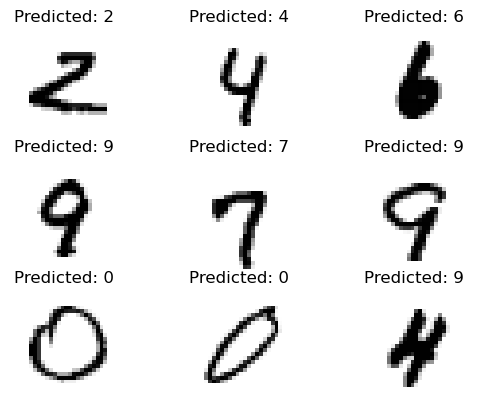

In [58]:
# Plot 
figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')
    plt.title("Predicted: {}".format(predicted[index].item()))
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')

### Saving Models
(Option 1) Save Model with Shapes
* save the structure of this class together with the model

In [59]:
torch.save(model,"MNIST_model.pth")

(Option 2) Save Model Weight as  state dictionary

In [60]:
torch.save(model.state_dict(), "MNIST_model2.pth")
print("Saved PyTorch Model State")

Saved PyTorch Model State


### Load the pretrained model

(Option 1) Loading a model with structures 

In [61]:
model = torch.load("MNIST_model.pth", weights_only=False)
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

(Option 2) Loading a model includes re-creating the model structure and loading the state dictionary into it.

* Need to `import` or define the Network Structure

In [62]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 250)
        self.linear2 = nn.Linear(250, 100)
        self.linear3 = nn.Linear(100, 10)

        
    def forward(self, x):
        x=self.flatten(x)
        x= F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y_pred = F.log_softmax(self.linear3(x))
        return y_pred

In [63]:
model2 = MLP().to(device)
print(model2)
model2.load_state_dict(torch.load('MNIST_model2.pth'))
model2.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)

### Test 
Print test data accuracy 

In [64]:
test(test_dataloader, model, loss_fn)

C:\Users\Sangheon\AppData\Local\Temp\ipykernel_29672\889195615.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


Test Error: 
 Accuracy: 91.8%, Avg loss: 0.285123 



### Visualize test results

Select random test images and evaluate

In [65]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
print(images.size())

# Evaluate mode
# Prediction of some sample images 
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    pred = model(images)
    _, predicted = torch.max(pred.data, 1)

torch.Size([64, 1, 28, 28])


C:\Users\Sangheon\AppData\Local\Temp\ipykernel_29672\889195615.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.log_softmax(self.linear3(x))


Plot some test image results

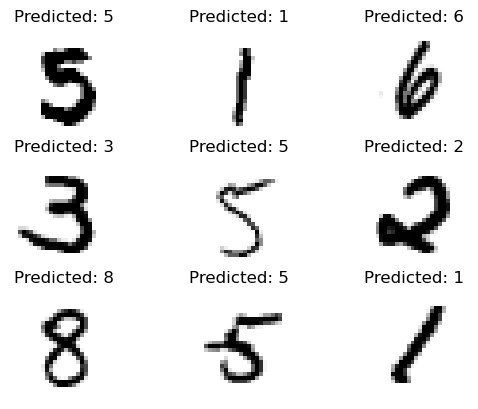

In [66]:
figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title("Predicted: {}".format(predicted[index].item()))
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')



---



# Exercise


## Exercise 1
Change, activation functions and optimization types for a better output.

In [67]:
# Model Architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 64)
        self.linear3 = nn.Linear(64, 10)


    def forward(self, x):
        x=self.flatten(x)
        x= F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y_pred = F.log_softmax(self.linear3(x))
        return y_pred


model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Train Module
def train(dataloader, model, loss_fn, optimizer):
    # Dataset Size
    size = len(dataloader.dataset)
    
    # Model in Training Mode
    model.train()

    running_loss=0.0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # zero gradients for every batch
        optimizer.zero_grad()   

        # Compute prediction loss 
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation and Update        
        loss.backward()
        optimizer.step()        

        # Print loss for every 100 batch in an epoch
        running_loss+=loss.item()
        if batch % 100 == 0:
            running_loss=running_loss/100
            current = batch * len(X)
            print(f"loss: {running_loss:>7f}  [{current:>5d}/{size:>5d}]")
            running_loss=0

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

In [ ]:
def test(dataloader, model, loss_fn):
    # Dataset Size
    size = len(dataloader.dataset)

    # Batch Size
    num_batches = len(dataloader)
    
    # Model in Evaluation Mode
    model.eval()

    test_loss, correctN = 0, 0
    
    # Disable grad() computation to reduce memory consumption.
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            # Compute average prediction loss 
            pred = model(X)            
            test_loss += loss_fn(pred, y).item()

            # Predict Label
            y_pred=pred.argmax(1);
            correctN += (y_pred == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correctN /= size
    print(f"Test Error: \n Accuracy: {(100*correctN):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
test(test_dataloader, model, loss_fn)

## Exercise 2
Rewrite  the above MLP model as the following.

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

